Based on a mix of 
https://github.com/dfm/george/blob/master/docs/_code/model.py
and
http://dan.iel.fm/george/current/user/hyper/

but adapted to do optimization on a model that includes GP and a signal component by Kyle on Aug 14, 2015

In [63]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [64]:
from __future__ import division, print_function

import emcee
#import triangle
import triangle_plot as triangle
import numpy as np
import matplotlib.pyplot as pl

import george
from george import kernels

import scipy.optimize as op


In [65]:
def model(params, t):
    amp, loc, sig2 = params
    return amp * np.exp(-0.5 * (t - loc) ** 2 / sig2)

In [66]:
def generate_data(params, N, rng=(-5, 5)):
    gp = george.GP(0.1 * kernels.ExpSquaredKernel(3.3))
    t = rng[0] + np.diff(rng) * np.sort(np.random.rand(N))
    y = gp.sample(t)
    y += model(params, t)
    yerr = 0.05 + 0.05 * np.random.rand(N)
    y += yerr * np.random.randn(N)
    return t, y, yerr

In [67]:
#we won't use this will use nll instead
def lnlike_gp(p, t, y, yerr):
    a, tau = np.exp(p[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(t, yerr)
    return gp.lnlikelihood(y - model(p[2:], t))


#we won't use this b/c we aren't using emcee
def lnprior_gp(p):
    lna, lntau = p[:2]
    if not -5 < lna < 5:
        return -np.inf
    if not -5 < lntau < 5:
        return -np.inf
    return lnprior_base(p[2:])


#we won't use this b/c we aren't using emcee

def lnprob_gp(p, t, y, yerr):
    lp = lnprior_gp(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_gp(p, t, y, yerr)


#we won't use this b/c we aren't using emcee
def fit_gp(initial, data, nwalkers=32):
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim)
          for i in xrange(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gp, args=data)

    print("Running burn-in")
    p0, lnp, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running second burn-in")
    p = p0[np.argmax(lnp)]
    p0 = [p + 1e-8 * np.random.randn(ndim) for i in xrange(nwalkers)]
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production")
    p0, _, _ = sampler.run_mcmc(p0, 5000)

    return sampler

In [68]:
def runToy(plots=False):
    truth = [1., 0.1, 0.4] #changed amplitdue to +1 for HEP not exoplanets
    t, y, yerr = generate_data(truth, 50)

    p = [0.0, 0.0] + truth

    a, tau = np.exp(p[:2])
    gp = george.GP(a * kernels.Matern32Kernel(tau))
    gp.compute(t, yerr)

    # Define the objective function (negative log-likelihood in this case).
    def nll(p):
        # The scipy optimizer doesn't play well with infinities.

        # Update the kernel parameters and compute the likelihood.
        gp.kernel[:] = p[:2]
        ll = gp.lnlikelihood(y - model(p[2:],t), quiet=True)
        #ll = gp.lnlikelihood(y , quiet=True)
        return -ll if np.isfinite(ll) else 1e25

    # And the gradient of the objective function.
    # we won't use this either
    def grad_nll(p):
        # Update the kernel parameters and compute the likelihood.
        gp.kernel[:] = p[:2]
        return -gp.grad_lnlikelihood(y - model(p[2:],t), quiet=True)
        #return -gp.grad_lnlikelihood(y , quiet=True)

    # Print the initial ln-likelihood.
    print(gp.lnlikelihood(y - model(p[2:],t)))

    # Run the optimization routine.
    #results = op.minimize(nll, p, jac=grad_nll) 
    # don't know gradient for other part of model
    
    results = op.minimize(nll, p)
    
    print(results.x)
    p = results.x
    
    # Update the kernel and print the final log-likelihood.
    gp.kernel[:] = results.x[:2]
    print(gp.lnlikelihood(y - model(p[2:],t)))


    if plots:
        # Plot the samples in data space.
        print("Making plots")
        x = np.linspace(-5, 5, 500)
        pl.figure()
        pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
        m, cov = gp.predict(y-model(p[2:],t), x)

        pl.plot(x, m, color="#4682b4", alpha=0.3)
        pl.plot(x, model(p[2:], x), color="r", alpha=0.3)
        pl.plot(x, m + model(p[2:], x), color="g", alpha=0.3)

        pl.ylabel(r"$y$")
        pl.xlabel(r"$t$")
        pl.xlim(-5, 5)
        pl.title("results with Gaussian process noise model")
        pl.savefig("gp-bestfit.png")
    
    print( p[2])
    return p[2]




15.41331803
[-1.51625279  3.95584627  0.80565782  0.05470704  0.39135082]
47.9155631921
Making plots
0.805657822905


0.80565782290530052

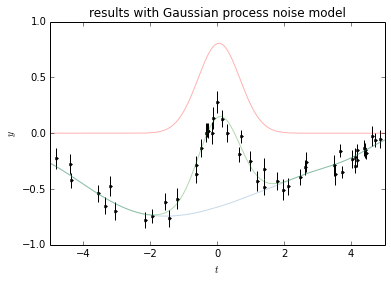

In [69]:
runToy(True)

In [70]:
ampArray = []
for i in range(100):
    try:
        ampArray.append(runToy(False))
    except ValueError:
        print("didnt' work")



10.5130329837
[-1.88152124  3.11820141  1.18211775  0.08629853  0.38843503]
39.7604591178
1.18211774686
9.26494351615
[-2.89093218  4.88919371  0.89003035  0.13527701  0.39970359]
47.6048965046
0.890030354939
12.9376133281
[-3.31906483  1.58281901  0.6433711   0.10227122  0.23400752]
44.8787107836
0.64337110044
14.1489237355
[-2.03314038  4.06745276  0.88600515  0.0865865   0.2968777 ]
45.8597827147
0.88600514811
14.9117800399
[-3.95413819  0.97107048  1.06785868  0.14287222  0.40103592]
47.8622676902
1.06785867871
16.8560203739
[-2.09708453  2.72838606  0.97549295  0.10134833  0.45994461]
48.0306003749
0.975492952271
10.9393361438
[-2.29455159  3.42523137  0.7702139   0.18327781  0.34659198]
40.5735842994
0.770213903033
11.2156938342
[-1.81096849  2.46457994  0.89795414  0.17097312  0.30310444]
40.5842214333
0.897954140168
17.5494779228
[-0.42598877  3.60127551  1.09983507  0.1166437   0.45332901]
48.9212581736
1.09983506812
15.0006538406
[-2.50281691  4.34024394  1.05027303  0.186737

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/linesearch.py:422: RuntimeWarning: invalid value encountered in double_scalars
  radical = B * B - 3 * A * C



43.3385564384
0.960301732078
16.3153660746
[-2.46453958  2.19176277  1.09786422  0.00725849  0.43707478]
44.7994000384
1.0978642174
13.5946922614
[-3.27927878  1.74731378  0.97731072  0.05959335  0.31702441]
45.3943206646
0.977310724779
16.3186571743
[-1.69374013  2.91916476  1.09807618  0.16863006  0.41220003]
42.7667710872
1.09807617834
14.6490941543
[-1.02773538  0.88835631  1.00478036  0.12670817  0.36502807]
30.9681931205
1.00478035979
13.3038738514
[-2.77195588  2.86728326  1.12689946  0.16442857  0.65612676]
42.8266459585
1.12689946047
15.8072836618
[-1.72834786  3.31255398  1.13070189  0.08517504  0.33864718]
47.6113890086
1.13070189415
16.9070536187
[-3.94320677  0.94144838  1.34819054  0.20134796  0.63722943]
49.48069514
1.34819053877
14.947443991
[-1.75790849  4.21623964  0.97301907  0.03279656  0.38640311]
52.0810212383
0.973019071588
14.1780928431
[-3.15516153  1.78213242  1.00417656  0.01595351  0.332391  ]
44.8550174758
1.00417656348
17.7803467482
[-2.08161091  3.190203

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/linesearch.py:427: RuntimeWarning: overflow encountered in double_scalars
  xmin = a + (-B + np.sqrt(radical)) / (3 * A)


1.02350504175


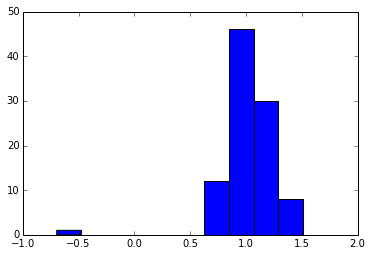

In [71]:
plt.hist(ampArray)
print(np.mean(ampArray))